In [1]:
# Important necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from matplotlib.lines import Line2D
from tqdm import *
from itertools import compress
from scipy.optimize import bisect
import math
%matplotlib inline  

In [2]:
def round_sigfigs(num, sig_figs):
    """Round to specified number of sigfigs.

    >>> round_sigfigs(0, sig_figs=4)
    0
    >>> int(round_sigfigs(12345, sig_figs=2))
    12000
    >>> int(round_sigfigs(-12345, sig_figs=2))
    -12000
    >>> int(round_sigfigs(1, sig_figs=2))
    1
    >>> '{0:.3}'.format(round_sigfigs(3.1415, sig_figs=2))
    '3.1'
    >>> '{0:.3}'.format(round_sigfigs(-3.1415, sig_figs=2))
    '-3.1'
    >>> '{0:.5}'.format(round_sigfigs(0.00098765, sig_figs=2))
    '0.00099'
    >>> '{0:.6}'.format(round_sigfigs(0.00098765, sig_figs=3))
    '0.000988'
    """
    if num != 0:
        return round(num, -int(math.floor(math.log10(abs(num))) - (sig_figs - 1)))
    else:
        return 0  # Can't take the log of 0


In [3]:
def combine_background_files(folder='../data/bkg_Zj/', lumi=37*1000, nfiles=200, cut=None,extra='', return_cxn = False, kf=1.0):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(extra)+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(extra)+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    mean_cxn  = np.mean([meta_frame['cxn'] for meta_frame in meta_frames])
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]*5000*kf
        
    data = pd.concat(evt_frames)
    
    if cut is not None:
        data = data.query(cut)
    if return_cxn:
        return data, mean_cxn
    else:
        return data

In [4]:
def to_str(num):
    if .2 <= num <= .9:
        return '{:.1g}'.format(num)[-2:]
    elif num == 0:
        return '0.0'
    elif num == 0.99:
        return '0.99'
    elif num == 1:
        return '1.0'
    else:
        return str(num)

def combine_signal_files(folder='../data/bkg_Zj/', mphi = 1700, rinv = 1, lumi=37*1000, nfiles=2, cut = None,extra='', return_cxn = False):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(extra)+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    mean_cxn  = np.mean([meta_frame['cxn'] for meta_frame in meta_frames])
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]


        
    data = pd.concat(evt_frames)
    
    if cut is not None:
        data = data.query(cut)
    if return_cxn:
        return data, mean_cxn
    else:
        return data

In [27]:
def signif(s, b ):
    return s/np.sqrt(s+b)

In [5]:
Zj_df = combine_background_files('../data/bkg_Zj/', nfiles=1000,kf=1.1)
Wj_df = combine_background_files('../data/bkg_Wj/', nfiles=1000,kf=1.)
tt_d_df = combine_background_files('../data/bkg_ttbar_dilep//', nfiles=1000,kf=1.7)
tt_s_df = combine_background_files('../data/bkg_ttbar_semilep//', nfiles=1000,kf=1.7)
QCD_df = combine_background_files('../data/bkg_qcd////', nfiles=2000,kf=1.0)

tt_df = pd.concat([tt_d_df, tt_s_df])

In [135]:
def limit(sig,bkg):
    if np.sum(sig)==0:
        return 1e99
    def func_root(x):
        part1 = bkg > 20
        part2 = np.logical_not(part1)
        qcd_1 = bkg[part1]
        qcd_2 = bkg[part2]
        sig_1 = sig[part1]
        sig_2 = sig[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(2*(sb1+0.00000000002**2*qcd_1**2))
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+(np.sum(logpart)+np.sum(sig_t2)) - 2
        return my_val
    
    
    soln = bisect(func_root, -10.,20.)
    return 10**soln

In [136]:
bkgs = [Zj_df, Wj_df, tt_df, QCD_df]

In [137]:
def get_bkg(bkg, cut=None):
    if cut not in [None,'']:
        new_bkg = bkg.query(cut)
    else: 
        new_bkg = bkg
    return np.sum(np.histogram(new_bkg['MEt'].values, weights=new_bkg['weight'].values)[0])

def get_sig(sig, cut=None):
    if cut not in [None,'']:
        new_bkg = sig.query(cut)
    else: 
        new_bkg = sig
    return np.sum(np.histogram(new_bkg['MEt'].values, weights=new_bkg['weight'].values)[0])

In [38]:
bkgs_list = [get_bkg(bkg, 'MEt > 0 & dphi < 0.4') for bkg in bkgs]

In [39]:
masses = [100000]
rinvs = [0.0, 0.01,0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.99, 1.0]

In [40]:
cuts = ['' for i in range(4)]
trigger_presel = 'pt1 > 250 & MEt > 200'
cuts[0] = ''
cuts[1] = ' & MEt > 800'
cuts[2] = ' & MEt > 800 & dphi < 0.4'
cuts[3] = ' & MEt > 800 & dphi > 0.4'

In [41]:
bkg_cutflow = [[round_sigfigs(get_bkg(bkg, trigger_presel + cut),3) for bkg in bkgs] for cut in cuts]

In [69]:
rinvs = 0.1, 0.5, 0.9

In [70]:
sigs = [combine_signal_files('../data/sig_zprime/', 100000, rinv, extra = '' , nfiles=16, return_cxn=True)[0] for rinv in rinvs]
cxns = [combine_signal_files('../data/sig_zprime/', 100000, rinv, extra = '' , nfiles=16, return_cxn=True)[1] for rinv in rinvs]

In [71]:
sig_cutflow = [[round_sigfigs(get_sig(sig,trigger_presel + cut)/cxn*1,3) for sig, cxn in zip(sigs, cxns)] for cut in cuts]

In [72]:
sig_cutflow_pd = pd.DataFrame(np.array(sig_cutflow).astype(np.int32))

In [73]:
bkg_cutflow_pd = pd.DataFrame(np.array(bkg_cutflow).astype(np.int32))

In [74]:
bk_sum = np.sum(bkg_cutflow, axis = 1)
bkg_cutflow_pd['4'] = pd.Series(bk_sum, index=bkg_cutflow_pd.index).astype(np.int32)

In [75]:
sig_sigs = [[round(signif(sig_cutflow[i][j],bk_sum[i]),2) for i in range(len(cuts))] for j in range(len(rinvs))]

In [76]:
for i in range(len(np.transpose(sig_cutflow))):
    sig_cutflow_pd.insert(2*i+1, 'sig'+str(i+1), sig_sigs[i]) 

In [77]:
for i in range(len(cuts)):
    for j in range(len(rinvs)):
        sig_cutflow[i][j] = str(int(sig_cutflow[i][j]) )+"("+str(np.transpose(sig_sigs)[i][j])+")"

In [78]:
sig_cutflow_pd = pd.DataFrame(np.array(sig_cutflow))

In [79]:
sig_cutflow_pd = pd.DataFrame(np.array(sig_cutflow))
bkg_cutflow_pd = pd.DataFrame(np.array(bkg_cutflow).astype(np.int32))

In [80]:
print pd.concat([sig_cutflow_pd, bkg_cutflow_pd], axis = 1).to_latex()

\begin{tabular}{llllrrrr}
\toprule
{} &           0 &           1 &           2 &       0 &       1 &      2 &      3 \\
\midrule
0 &  2000(2.58) &  4920(6.33) &  2340(3.02) &  225037 &  247273 &  68865 &  57311 \\
1 &    43(1.01) &   174(3.94) &   108(2.49) &    1161 &     535 &     80 &      0 \\
2 &     0(0.02) &    31(0.88) &     73(2.0) &    1051 &     209 &      8 &      0 \\
3 &    42(1.81) &   142(5.57) &    35(1.51) &     109 &     326 &     72 &      0 \\
\bottomrule
\end{tabular}



In [138]:
benchmarks = [[0.5, 1500], [0.9, 2000]]

In [139]:
cuts = ['' for i in range(4)]
trigger_presel = 'pt1 > 250 & MEt > 200'
cuts[0] = ''
cuts[1] = ' & MEt > 800'
# cuts[2] = ' & pt2 > 120'
# cuts[3] = ' & pt1 + pt2 + pt3 + pt4 > 800'
cuts[2] = ' & dphi > 0.4'
cuts[3] = ' & dphi < 0.4'

for i in range(1,3):
    cuts[i] += cuts[i-1]
    
cuts[3] += cuts[1]

In [140]:
cuts

['', ' & MEt > 800', ' & dphi > 0.4 & MEt > 800', ' & dphi < 0.4 & MEt > 800']

In [141]:
bkg_cutflow = [[get_bkg(bkg, trigger_presel + cut) for bkg in bkgs] for cut in cuts]

In [142]:
sigs = [combine_signal_files('../data/sig_tchannel/', mass, rinv, extra = '' , nfiles=1, return_cxn=True)[0] for rinv, mass  in benchmarks]
cxns = [combine_signal_files('../data/sig_tchannel/', mass, rinv, extra = '' , nfiles=1, return_cxn=True)[1] for rinv, mass in benchmarks]

In [143]:
sig_cutflow = [[get_sig(sig,trigger_presel + cut) for sig, cxn in zip(sigs, cxns)] for cut in cuts]

In [144]:
bk_sum = np.sum(bkg_cutflow, axis = 1)

In [145]:
sig_sigs = [[round(signif(sig_cutflow[i][j],bk_sum[i]),2) for i in range(len(cuts))] for j in range(len(benchmarks))]

In [146]:
for i in range(len(cuts)):
    for j in range(len(benchmarks)):
        sig_cutflow[i][j] = str(int(sig_cutflow[i][j]) )+"("+str(np.transpose(sig_sigs)[i][j])+")"

In [147]:
sig_cutflow_pd = pd.DataFrame(np.array(sig_cutflow))
bkg_cutflow_pd = pd.DataFrame(np.array(bkg_cutflow).astype(np.int32))

In [148]:
bkg_cutflow_pd['4'] = pd.Series(bk_sum, index=bkg_cutflow_pd.index).astype(np.int32)

In [149]:
print pd.concat([sig_cutflow_pd, bkg_cutflow_pd], axis = 1).to_latex()

\begin{tabular}{lllrrrrr}
\toprule
{} &          0 &         1 &       0 &       1 &      2 &      3 &       4 \\
\midrule
0 &  2091(2.7) &  467(0.6) &  225037 &  247273 &  68865 &  57311 &  598487 \\
1 &   50(1.17) &  96(2.22) &    1161 &     535 &     80 &      0 &    1777 \\
2 &   13(0.38) &  64(1.77) &    1051 &     209 &      8 &      0 &    1268 \\
3 &   36(1.57) &  31(1.35) &     109 &     326 &     72 &      0 &     508 \\
\bottomrule
\end{tabular}



In [130]:
benchmarks = [[0., 1500], [0.3, 1500]]

In [131]:
cuts = ['' for i in range(2)]
trigger_presel = 'pt1 > 440 & pt2 > 60'
cuts[0] = ''
cuts[1] = ' & 1.2 > y1-y2 > -1.2'

for i in range(1,2):
    cuts[i] += cuts[i-1]
    
# cuts[5] += cuts[3]

In [132]:
bkg_cutflow = [[round_sigfigs(get_bkg(bkg, trigger_presel + cut),3) for bkg in bkgs] for cut in cuts]
sigs = [combine_signal_files('../data/sig_zprime/', mass, rinv, extra = '' , nfiles=4, return_cxn=True)[0] for rinv, mass  in benchmarks]
cxns = [combine_signal_files('../data/sig_zprime/', mass, rinv, extra = '' , nfiles=4, return_cxn=True)[1] for rinv, mass in benchmarks]

In [419]:
sig_cutflow = [[round_sigfigs(get_sig(sig,trigger_presel + cut),3) for sig, cxn in zip(sigs, cxns)] for cut in cuts]

In [420]:
bk_sum = np.sum(bkg_cutflow, axis = 1)

In [421]:
sig_sigs = [[round(signif(sig_cutflow[i][j],bk_sum[i]),2) for i in range(len(cuts))] for j in range(len(benchmarks))]

In [422]:
for i in range(len(cuts)):
    for j in range(len(benchmarks)):
        sig_cutflow[i][j] = str(int(sig_cutflow[i][j]) )+"("+str(np.transpose(sig_sigs)[i][j])+")"

In [423]:
sig_cutflow_pd = pd.DataFrame(np.array(sig_cutflow))
bkg_cutflow_pd = pd.DataFrame(np.array(bkg_cutflow).astype(np.int32))

In [424]:
bkg_cutflow_pd['4'] = pd.Series(bk_sum, index=bkg_cutflow_pd.index).astype(np.int32)

In [425]:
print pd.concat([sig_cutflow_pd, bkg_cutflow_pd], axis = 1).to_latex()

\begin{tabular}{lllrrrrr}
\toprule
{} &           0 &           1 &      0 &       1 &      2 &         3 &         4 \\
\midrule
0 &   9860(1.8) &  6770(1.23) &  70900 &  143000 &  54100 &  29800000 &  30068000 \\
1 &  6630(1.62) &  5060(1.24) &  41100 &   83200 &  36700 &  16500000 &  16661000 \\
\bottomrule
\end{tabular}



In [426]:
bkg_sum = pd.concat(bkgs)

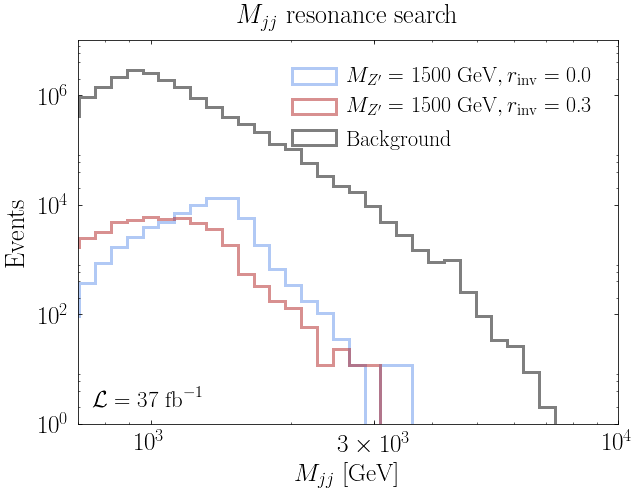

In [427]:
fig=plt.figure(figsize=(9,7))
sig_cuts = [sig.query(trigger_presel + cuts[-1]) for sig in sigs]
bkg_cut = bkg_sum.query(trigger_presel + cuts[-1])
for isig, sig_cut in enumerate(sig_cuts):
    plt.hist(sig_cut['mjj'], weights=10*sig_cut['weight'].values, histtype='step', bins = np.logspace(2,4,60), lw= 3, alpha=0.5, label = "$M_{Z^\prime} = $ " + str(benchmarks[isig][1]) + " GeV$, r_\mathrm{inv}$ = " + str(benchmarks[isig][0]), color=plot_colors[isig])
plt.hist(bkg_cut['mjj'], weights=bkg_cut['weight'].values, histtype='step', bins = np.logspace(2,4,60), lw=3, alpha=0.5, color='black', label="Background")
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xscale("log")
plt.xlim(700,10000)
plt.ylabel("Events", fontsize=26)
plt.xlabel("$M_{jj}$ [GeV]", fontsize=25)
plt.ylim(1,1e7)
leg = plt.legend(bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=22, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0., loc='upper right')
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([10**3,3*10**3,10**4],["$10^3$","$3 \\times 10^3$","$10^4$"])
plt.title("$M_{jj}$ resonance search", fontsize=26)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])
plt.text(750,2,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=23)
plt.tight_layout()
plt.savefig("ResSearch.pdf")

In [428]:
Zj_df = combine_background_files('../data/bkg_Zj/', nfiles=1000, extra='reclustered_',kf=1.1)
Wj_df = combine_background_files('../data/bkg_Wj/', nfiles=1000, extra='reclustered_',kf=1.)
tt_d_df = combine_background_files('../data/bkg_ttbar_dilep//', nfiles=1000, extra='reclustered_',kf=1.7)
tt_s_df = combine_background_files('../data/bkg_ttbar_semilep//', nfiles=1000, extra='reclustered_',kf=1.7)
QCD_df = combine_background_files('../data/bkg_qcd//', nfiles=2000, extra='reclustered_',kf=1.)

tt_df = pd.concat([tt_d_df,tt_s_df])

In [429]:
bkgs = [Zj_df, Wj_df, tt_df, QCD_df]

In [430]:
benchmarks = [[0.1, 2000], [0.5, 2000]]

In [431]:
cuts = ['' for i in range(4)]
trigger_presel = 'pt2> 100 & MEt > 200'
cuts[0] = ''
cuts[1] = ' & MEt > .15*Mt'
cuts[2] = ' & 1.1 > eta1-eta2 > -1.1'
cuts[3] = ' & dphi < 0.4'


for i in range(1,4):
    cuts[i] += cuts[i-1]
    
# cuts[5] += cuts[3]

In [432]:
bkg_cutflow = [[round_sigfigs(get_bkg(bkg, trigger_presel + cut),3) for bkg in bkgs] for cut in cuts]
sigs = [combine_signal_files('../data/sig_zprime/', mass, rinv, extra = 'reclustered_' , nfiles=4, return_cxn=True)[0] for rinv, mass  in benchmarks]
cxns = [combine_signal_files('../data/sig_zprime/', mass, rinv, extra = 'reclustered_' , nfiles=4, return_cxn=True)[1] for rinv, mass in benchmarks]

In [433]:
sig_cutflow = [[round_sigfigs(get_sig(sig,trigger_presel + cut),3) for sig, cxn in zip(sigs, cxns)] for cut in cuts]

In [434]:
bk_sum = np.sum(bkg_cutflow, axis = 1)

In [435]:
sig_sigs = [[round(signif(sig_cutflow[i][j],bk_sum[i]),2) for i in range(len(cuts))] for j in range(len(benchmarks))]

In [436]:
for i in range(len(cuts)):
    for j in range(len(benchmarks)):
        sig_cutflow[i][j] = str(int(sig_cutflow[i][j]) )+"("+str(np.transpose(sig_sigs)[i][j])+")"

In [437]:
sig_cutflow_pd = pd.DataFrame(np.array(sig_cutflow))
bkg_cutflow_pd = pd.DataFrame(np.array(bkg_cutflow).astype(np.int32))

In [438]:
bkg_cutflow_pd['4'] = pd.Series(bk_sum, index=bkg_cutflow_pd.index).astype(np.int32)

In [439]:
print pd.concat([sig_cutflow_pd, bkg_cutflow_pd], axis = 1).to_latex()

\begin{tabular}{lllrrrrr}
\toprule
{} &          0 &           1 &       0 &       1 &      2 &      3 &       4 \\
\midrule
0 &  634(1.03) &   1360(2.2) &  108000 &  141000 &  68100 &  64400 &  381500 \\
1 &  403(0.69) &  1250(2.13) &  102000 &  131000 &  63700 &  46300 &  343000 \\
2 &  250(0.58) &   756(1.75) &   51700 &   71200 &  38900 &  24900 &  186700 \\
3 &  239(0.79) &   637(2.11) &   11100 &   33400 &  21800 &  24300 &   90600 \\
\bottomrule
\end{tabular}



In [440]:
plot_colors = ['cornflowerblue','firebrick']

In [441]:
bkg_sum = pd.concat(bkgs)

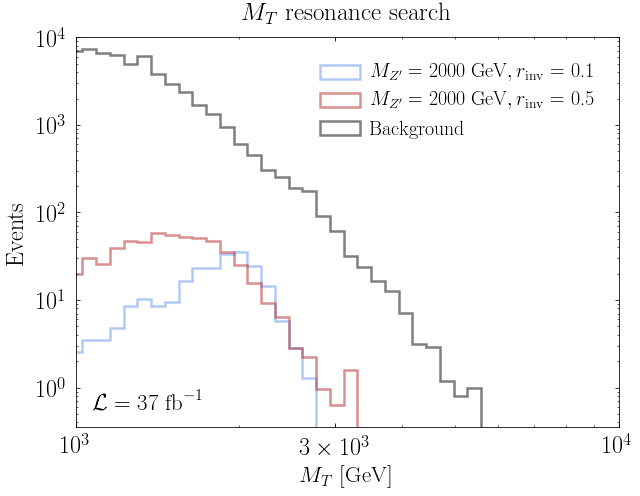

In [442]:
fig=plt.figure(figsize=(9,7))
sig_cuts = [sig.query(trigger_presel + cuts[-1]) for sig in sigs]
bkg_cut = bkg_sum.query(trigger_presel + cuts[-1])
for isig, sig_cut in enumerate(sig_cuts):
    plt.hist(sig_cut['Mt'], weights=sig_cut['weight'].values, histtype='step', bins = np.logspace(2,4,80), lw= 2.5, alpha=0.5, label = "$M_{Z^\prime} = $ " + str(benchmarks[isig][1]) + " GeV$, r_\mathrm{inv}$ = " + str(benchmarks[isig][0]), color=plot_colors[isig])
    sig_plus_bkg = pd.concat([sig_cut, bkg_cut])    
#     plt.hist(sig_plus_bkg['Mt'], weights=sig_plus_bkg['weight'], histtype='step', bins = np.linspace(100,8000,100), lw=2.5, alpha=0.5, color=plot_colors[isig])
plt.hist(bkg_cut['Mt'], weights=bkg_cut['weight'].values, histtype='step', bins = np.logspace(2,4,80), lw=2.5, alpha=0.5, color='black', label="Background")


plt.yscale("log")
plt.xscale("log")
plt.gca().set_xscale("log")
plt.xlim(1000,10000)
plt.ylabel("Events", fontsize=24)
plt.xlabel("$M_{T}$ [GeV]", fontsize=23)
plt.ylim(0.35,10**4)
leg = plt.legend(bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0., loc='upper right')
plt.tick_params(axis='both', which='major', labelsize=24)
plt.title("$M_T$ resonance search", fontsize=25)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])
plt.xticks([10**3,3*10**3,10**4],["$10^3$","$3 \\times 10^3$","$10^4$"])
plt.text(1070,0.55,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=23)
plt.tight_layout()
plt.savefig("MTSearch.pdf")